# Markdown 
Otras formas de trabajo
#   Datos a usar
cuántitativas:

P3094S3 : Cuánto ahorro por cultivar.

P3087S1: Valor mensual por practicas o pasantías.

P3095S3: Valor ahorra por criar animales.

# Cualitativas
P3101: ¿Fue a reuniones familiares durante las ultimas 4 semanas? si o no.

# agrupar estas variables para los 3 meses 

In [9]:
library(readr)
library(dplyr)

# Archivos
csv_files <- c(
  "Mayo_2024 1/CSV/Otras formas de trabajo.CSV",
  "Junio_2024/CSV/Otras formas de trabajo.CSV",
  "Julio_2024/CSV/Otras formas de trabajo.CSV"
)

# Columnas necesarias
cols_needed <- c("P3094S3", "P3087S1", "P3095S3", "P3101")

# Función para leer y limpiar
read_and_clean <- function(file) {
  df <- read_delim(
    file,
    delim = ";",
    col_names = TRUE,
    show_col_types = FALSE,
    locale = locale(encoding = "UTF-8"),
    guess_max = 10000
  )
  
  # Seleccionar solo las columnas necesarias
  df <- df %>% select(any_of(cols_needed))
  
  # Limpiar y convertir valores monetarios
  df <- df %>%
    mutate(
      across(c("P3094S3", "P3087S1", "P3095S3"), ~ {
        x <- as.character(.)
        x <- gsub("\\.", "", x)   # eliminar puntos de miles
        x <- gsub(",", ".", x)    # convertir coma a punto decimal si la hay
        suppressWarnings(as.numeric(x))
      })
    )
  
  return(df)
}

# Leer y combinar
combined <- bind_rows(lapply(csv_files, read_and_clean))

# Guardar
write_csv(combined, "Combinado.csv")

cat("✅ Archivo combinado guardado en: Combinado.csv\n")


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"


✅ Archivo combinado guardado en: Combinado.csv


In [10]:
# ---- Celda 1: Lectura y limpieza -------------------------------------------
library(readr); library(dplyr)

data_path <- "Combinado.csv"
varname   <- "P3087S1"   # variable con la que trabajamos
out_dir   <- "analisis_P3087S1_check"
dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)

# Leer todo como carácter para evitar parseos automáticos
df_char <- readr::read_csv(data_path,
                           col_types = readr::cols(.default = "c"),
                           locale = readr::locale(encoding = "UTF-8"),
                           show_col_types = FALSE)

# detectar nombre real (insensible a mayúsculas)
if (!varname %in% names(df_char)) {
  guess <- names(df_char)[tolower(names(df_char)) %in% tolower(varname)]
  if (length(guess) == 1) varname_real <- guess else stop("No encontré la variable ", varname)
} else varname_real <- varname

# función robusta de limpieza numérica (monedas, separadores, etc.)
clean_numeric2 <- function(x) {
  x <- as.character(x)
  x[ x %in% c("", "NA", NA) ] <- NA_character_
  x <- trimws(x)
  x <- gsub("\\s+", "", x)
  x <- gsub("[^0-9\\,\\.-]", "", x)
  both <- grepl("\\.", x) & grepl(",", x)
  if (any(both)) { x[both] <- gsub("\\.", "", x[both]); x[both] <- gsub(",", ".", x[both]) }
  only_comma <- grepl(",", x) & !grepl("\\.", x)
  x[only_comma] <- gsub(",", ".", x[only_comma])
  suppressWarnings(as.numeric(x))
}

# preparar df_var con la variable limpia y sin modificar el CSV original
df_var <- df_char %>%
  transmute(
    value_raw = .data[[varname_real]],
    value = clean_numeric2(.data[[varname_real]])
  )

# info rápida
cat("Variable real detectada:", varname_real, "\n")
cat("Total filas:", nrow(df_var), "   N no-missing:", sum(!is.na(df_var$value)), "\n")
# ver primeras filas
print(head(df_var, 10))


Variable real detectada: P3087S1 
Total filas: 166341    N no-missing: 336 
# A tibble: 10 × 2
   value_raw value
   <chr>     <dbl>
 1 NA           NA
 2 NA           NA
 3 NA           NA
 4 NA           NA
 5 NA           NA
 6 NA           NA
 7 NA           NA
 8 NA           NA
 9 NA           NA
10 NA           NA


In [11]:
# ---- Celda 2: Descriptivos Básicos ----------------------------------------
library(dplyr)

# usa df_var (si no existe la lee desde datos)
if (!exists("df_var")) {
  data_path <- "Combinado.csv"
  df_var <- readr::read_csv(data_path, col_types = readr::cols(.default = "c"), show_col_types = FALSE) %>%
    transmute(value_raw = .data[[varname]], value = clean_numeric2(.data[[varname]]))
}

x <- df_var$value
x_nm <- x[!is.na(x)]

# calcular medidas
N_total <- length(x)
N_missing <- sum(is.na(x))
Min <- ifelse(length(x_nm)>0, min(x_nm, na.rm=TRUE), NA)
Q1  <- ifelse(length(x_nm)>0, quantile(x_nm, .25, na.rm=TRUE), NA)
Median <- ifelse(length(x_nm)>0, median(x_nm, na.rm=TRUE), NA)
Mean <- ifelse(length(x_nm)>0, mean(x_nm, na.rm=TRUE), NA)
Q3 <- ifelse(length(x_nm)>0, quantile(x_nm, .75, na.rm=TRUE), NA)
Max <- ifelse(length(x_nm)>0, max(x_nm, na.rm=TRUE), NA)
SD <- ifelse(length(x_nm)>0, sd(x_nm, na.rm=TRUE), NA)
IQRv <- ifelse(length(x_nm)>0, IQR(x_nm, na.rm=TRUE), NA)

tabla_vertical <- tibble(
  Medida = c("N total","N missing","Min.","1st Qu.","Median","Mean","3rd Qu.","Max.","SD","IQR"),
  Valor  = c(N_total, N_missing, Min, Q1, Median, Mean, Q3, Max, SD, IQRv)
)

cat("=== Descriptivos Básicos ===\n")
print(tabla_vertical)

# Mostrar estadísticas resumidas estilo summary()
cat("\n=== Summary (sobre valores no-missing) ===\n")
print(summary(x_nm))


=== Descriptivos Básicos ===
# A tibble: 10 × 2
   Medida       Valor
   <chr>        <dbl>
 1 N total    166341 
 2 N missing  166005 
 3 Min.        80000 
 4 1st Qu.    750000 
 5 Median     975000 
 6 Mean       998708.
 7 3rd Qu.   1300000 
 8 Max.      9000000 
 9 SD         621977.
10 IQR        550000 

=== Summary (sobre valores no-missing) ===
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  80000  750000  975000  998708 1300000 9000000 


Gráficos guardados en: analisis_P3087S1_check/plots



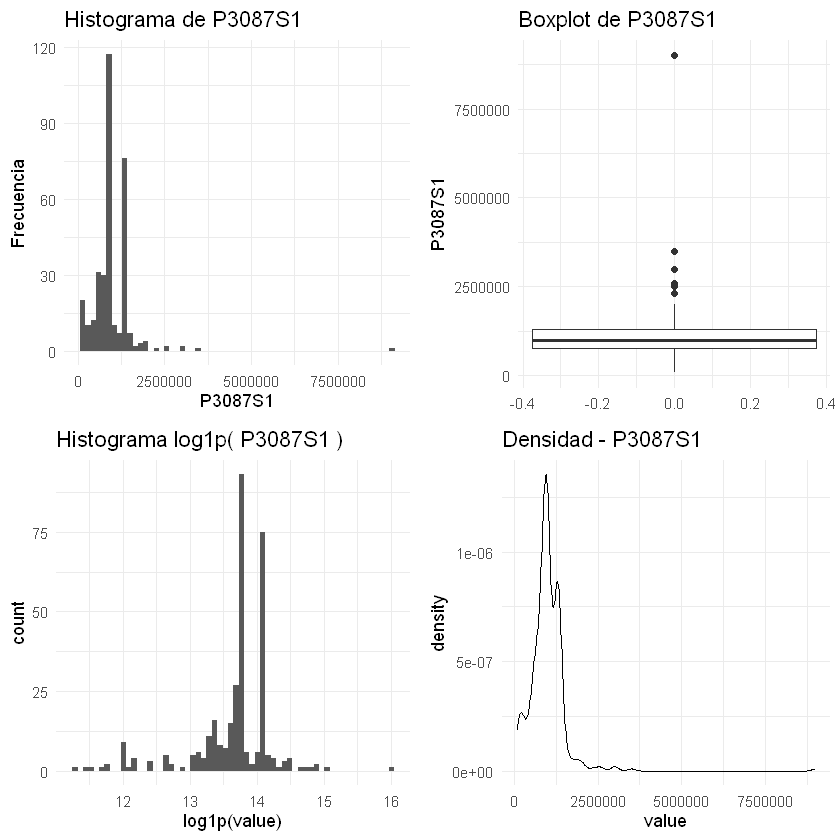

In [12]:
# ---- Celda 3: Análisis Gráfico --------------------------------------------
if (!requireNamespace("gridExtra", quietly = TRUE)) {
  install.packages("gridExtra", repos = "https://cloud.r-project.org")
}
library(gridExtra)
library(ggplot2)

plot_dir <- file.path(out_dir, "plots")
dir.create(plot_dir, showWarnings = FALSE, recursive = TRUE)

x <- df_var$value
x_nm <- x[!is.na(x)]

if (length(x_nm) == 0) {
  message("No hay datos no-missing: no se generan gráficos.")
} else {
  df_plot <- df_var %>% filter(!is.na(value))

  # Histograma lineal
  ph <- ggplot(df_plot, aes(x=value)) +
    geom_histogram(bins = 60) +
    labs(title = paste("Histograma de", varname_real), x = varname_real, y = "Frecuencia") +
    theme_minimal()
  ggsave(file.path(plot_dir, paste0("hist_", varname_real, ".png")), ph, width=8, height=4)

  # Boxplot
  pb <- ggplot(df_plot, aes(y=value)) +
    geom_boxplot() +
    labs(title = paste("Boxplot de", varname_real), y = varname_real) +
    theme_minimal()
  ggsave(file.path(plot_dir, paste0("boxplot_", varname_real, ".png")), pb, width=6, height=4)

  # Histograma log1p (si hay valores > 0)
  pl <- NULL
  if (any(df_plot$value > 0, na.rm=TRUE)) {
    df_plot <- df_plot %>% mutate(value_log1p = log1p(value))
    pl <- ggplot(df_plot, aes(x=value_log1p)) + 
      geom_histogram(bins = 60) +
      labs(title = paste("Histograma log1p(", varname_real, ")"), x = "log1p(value)") + 
      theme_minimal()
    ggsave(file.path(plot_dir, paste0("hist_log1p_", varname_real, ".png")), pl, width=8, height=4)
  }

  # Density
  pd <- ggplot(df_plot, aes(x=value)) + geom_density() + theme_minimal() +
    labs(title = paste("Densidad -", varname_real))
  ggsave(file.path(plot_dir, paste0("density_", varname_real, ".png")), pd, width=8, height=4)

  # Mostrar todas las gráficas juntas
  if (!is.null(pl)) {
    grid.arrange(ph, pb, pl, pd, ncol = 2)
  } else {
    grid.arrange(ph, pb, pd, ncol = 2)
  }

  message("Gráficos guardados en: ", plot_dir)
}


In [13]:
# ---- Celda 4 mejorada: Cálculo de los estimadores --------------------------
library(dplyr)
library(boot)

set.seed(12345)

# asegurar df_var existe y contiene 'value' (si no, leer el combinado y limpiar)
if (!exists("df_var") || !"value" %in% names(df_var)) {
  message("df_var no está en memoria -> leyendo desde Combinado.csv y limpiando")
  data_path <- "C:/Users/juand/OneDrive/libros/estadistica2taller1/Combinado.csv"
  # pequeña función de limpieza (reusa la que ya tienes)
  clean_numeric2 <- function(x) {
    x <- as.character(x)
    x[ x %in% c("", "NA", NA) ] <- NA_character_
    x <- trimws(x)
    x <- gsub("\\s+", "", x)
    x <- gsub("[^0-9\\,\\.-]", "", x)
    both <- grepl("\\.", x) & grepl(",", x)
    if (any(both)) { x[both] <- gsub("\\.", "", x[both]); x[both] <- gsub(",", ".", x[both]) }
    only_comma <- grepl(",", x) & !grepl("\\.", x)
    x[only_comma] <- gsub(",", ".", x[only_comma])
    suppressWarnings(as.numeric(x))
  }
  df_char <- readr::read_csv(data_path, col_types = readr::cols(.default = "c"), show_col_types = FALSE)
  # detectar varname_real si existe
  varname <- "P3095S3"
  if (!varname %in% names(df_char)) {
    guess <- names(df_char)[tolower(names(df_char)) %in% tolower(varname)]
    if (length(guess) == 1) varname_real <- guess else stop("No encontré la variable ", varname)
  } else varname_real <- varname
  df_var <- df_char %>% transmute(value_raw = .data[[varname_real]], value = clean_numeric2(.data[[varname_real]]))
}

x <- df_var$value
x_nm <- x[!is.na(x)]

# mensajes si pocos datos
cat("Total observaciones (N):", length(x), "\n")
cat("No-missing (n):", length(x_nm), "\n\n")

if (length(x_nm) == 0) stop("No hay datos no-missing para calcular estimadores.")

# 1) Estimadores puntuales
est_mean   <- mean(x_nm)
est_median <- median(x_nm)

# moda: si hay empates, devolvemos todas las modas y también la más frecuente
mode_basic_all <- function(v) {
  v2 <- v[!is.na(v)]
  if (length(v2) == 0) return(NA)
  tb <- sort(table(v2), decreasing = TRUE)
  names(tb)[tb == max(tb)]
}
modes <- mode_basic_all(x_nm)
mode_report <- paste(modes, collapse = ", ")

cat("Estimadores puntuales:\n")
cat(sprintf(" Mean: %s\n Median: %s\n Mode(s): %s\n\n",
            format(round(est_mean, 2), big.mark = ","), format(round(est_median, 2), big.mark=","), mode_report))

# 2) IC 95% para la media (t-interval, usando t.test)
if (length(x_nm) > 1) {
  tt <- try(t.test(x_nm), silent = TRUE)
  if (inherits(tt, "try-error")) {
    cat("No se pudo calcular t-interval por t.test():", tt, "\n")
  } else {
    ci_t <- tt$conf.int
    cat("IC 95% para la media (t): [", format(round(ci_t[1],2), big.mark=","), ", ", format(round(ci_t[2],2), big.mark=","), "]\n\n")
  }
} else cat("No hay suficientes datos para IC t.\n\n")

# 3) Bootstrap para mean y median
B <- 100  # puedes aumentar si tienes tiempo
cat("Ejecutando bootstrap con R =", B, "réplicas (esto puede tardar)...\n")

# helper para safe boot.ci
safe_boot_ci <- function(boot_obj, type = c("perc","bca","basic")) {
  out <- list()
  for (t in type) {
    res <- try(boot.ci(boot_obj, type = t), silent = TRUE)
    if (!inherits(res, "try-error") && !is.null(res[[t]])) {
      out[[t]] <- res
    } else {
      # si falló, intentamos extraer percentiles directos como fallback
      out[[t]] <- NULL
    }
  }
  out
}

# bootstrap mean
boot_mean <- try(boot(x_nm, statistic = function(d, i) mean(d[i]), R = B), silent = TRUE)
if (inherits(boot_mean, "try-error")) {
  cat("Bootstrap mean falló:", boot_mean, "\n")
} else {
  # intentar boot.ci para mean (perc y bca preferiblemente)
  ci_mean <- tryCatch({
    pci <- boot.ci(boot_mean, type = c("perc","bca"))
    pci
  }, error = function(e) e)
  if (inherits(ci_mean, "error")) {
    # fallback: percentiles directos
    ci_mean_perc <- quantile(boot_mean$t, probs = c(0.025, 0.975), na.rm = TRUE)
    cat("Bootstrap IC (perc) mean (fallback percentiles):", format(round(ci_mean_perc[1],2), big.mark=","), format(round(ci_mean_perc[2],2), big.mark=","), "\n")
  } else {
    # si boot.ci devolvió, imprimir los percentiles de 'perc' si existen
    if (!is.null(ci_mean$percent)) {
      ci_vals <- ci_mean$percent[4:5]
      cat("Bootstrap IC (perc) mean:", format(round(ci_vals[1],2), big.mark=","), format(round(ci_vals[2],2), big.mark=","), "\n")
    } else {
      # último recurso: percentiles de boot$t
      ci_mean_perc <- quantile(boot_mean$t, probs = c(0.025, 0.975), na.rm = TRUE)
      cat("Bootstrap IC mean (percentiles directos):", format(round(ci_mean_perc[1],2), big.mark=","), format(round(ci_mean_perc[2],2), big.mark=","), "\n")
    }
  }
}

# bootstrap median
boot_median <- try(boot(x_nm, statistic = function(d, i) median(d[i]), R = B), silent = TRUE)
if (inherits(boot_median, "try-error")) {
  cat("Bootstrap median falló:", boot_median, "\n")
} else {
  # a veces boot.ci falla si todas las réplicas son iguales (p. ej. datos discretos con muchos empates)
  ci_med_try <- tryCatch({
    ci_m <- boot.ci(boot_median, type = c("perc","bca"))
    ci_m
  }, error = function(e) e)
  if (inherits(ci_med_try, "error")) {
    # fallback: percentiles directos
    med_perc <- tryCatch({
      quantile(boot_median$t, probs = c(0.025, 0.975), na.rm = TRUE)
    }, error = function(e) NULL)
    if (!is.null(med_perc)) {
      cat("Bootstrap IC (perc) median (fallback percentiles):", format(round(med_perc[1],2), big.mark=","), format(round(med_perc[2],2), big.mark=","), "\n")
    } else {
      cat("Bootstrap IC median: no disponible (poca variabilidad en réplicas)\n")
    }
  } else {
    if (!is.null(ci_med_try$percent)) {
      ci_vals_med <- ci_med_try$percent[4:5]
      cat("Bootstrap IC (perc) median:", format(round(ci_vals_med[1],2), big.mark=","), format(round(ci_vals_med[2],2), big.mark=","), "\n")
    } else {
      cat("Bootstrap IC median calculado, pero formato inesperado; usando percentiles directos.\n")
      med_perc <- quantile(boot_median$t, probs = c(0.025, 0.975), na.rm = TRUE)
      cat("Bootstrap IC median (percentiles):", format(round(med_perc[1],2), big.mark=","), format(round(med_perc[2],2), big.mark=","), "\n")
    }
  }
}

cat("\nFIN Celda 4: estimadores y CIs calculados.\n")


Total observaciones (N): 166341 
No-missing (n): 336 

Estimadores puntuales:
 Mean: 998,708.3
 Median: 975,000
 Mode(s): 1300000

IC 95% para la media (t): [ 931,962.4 ,  1,065,454 ]

Ejecutando bootstrap con R = 100 réplicas (esto puede tardar)...


Warning message in norm.inter(t, adj.alpha):
"extreme order statistics used as endpoints"


Bootstrap IC (perc) mean: 937,753.5 1,060,171 
Bootstrap IC (perc) median (fallback percentiles): 973,687.5 975,000 

FIN Celda 4: estimadores y CIs calculados.


In [14]:
# ---- Celda 5: Insesgamiento (bias) mediante bootstrap ----------------------
library(boot)
set.seed(2025)

x <- df_var$value
x_nm <- x[!is.na(x)]

if (length(x_nm) > 5) {
  B <- 1000
  boot_mean <- boot(x_nm, statistic = function(data, idx) mean(data[idx]), R = B)
  boot_median <- boot(x_nm, statistic = function(data, idx) median(data[idx]), R = B)

  bias_mean <- mean(boot_mean$t) - est_mean
  bias_median <- mean(boot_median$t) - est_median

  cat("Bias estimado (bootstrap):\n")
  cat(" Mean bias:", bias_mean, "\n")
  cat(" Median bias:", bias_median, "\n")

  # mostrar distribuciones bootstrap rápidas (imprime cuantiles)
  cat("\nQuantiles bootstrap mean (2.5%,50%,97.5%): ", quantile(boot_mean$t, c(.025,.5,.975)), "\n")
  cat("Quantiles bootstrap median (2.5%,50%,97.5%): ", quantile(boot_median$t, c(.025,.5,.975)), "\n")

  cat("\nComentario sobre insesgamiento:\n")
  if (abs(bias_mean) < 0.01 * abs(est_mean) ) cat(" La media muestra sesgo pequeño relativo.\n") else cat(" La media muestra sesgo apreciable relativo — considerar estimadores robustos.\n")
  if (abs(bias_median) < 0.01 * abs(est_median) ) cat(" La mediana muestra sesgo pequeño relativo.\n") else cat(" La mediana muestra sesgo apreciable relativo.\n")
} else {
  cat("No hay suficientes datos para estimar bias con bootstrap.\n")
}


Bias estimado (bootstrap):
 Mean bias: 333.1518 
 Median bias: -282.5 

Quantiles bootstrap mean (2.5%,50%,97.5%):  937685 996995.5 1072765 
Quantiles bootstrap median (2.5%,50%,97.5%):  970000 975000 975000 

Comentario sobre insesgamiento:
 La media muestra sesgo pequeño relativo.
 La mediana muestra sesgo pequeño relativo.


    n   var_mean  var_median
1  50 6687514241 216671126.0
2  90 3193676887  17308458.8
3 131 2131403215  16418049.1
4 172 1039056937    430532.3
5 213  681761349    248327.8
6 254  357293667         0.0
7 295  166413041         0.0
8 336          0         0.0


Gráfico de consistencia guardado en: analisis_P3087S1_check/consistencia_var_vs_n.png




Comentario (Consistencia):
Si la varianza del estimador (mean o median) disminuye al crecer n, evidencia consistencia.


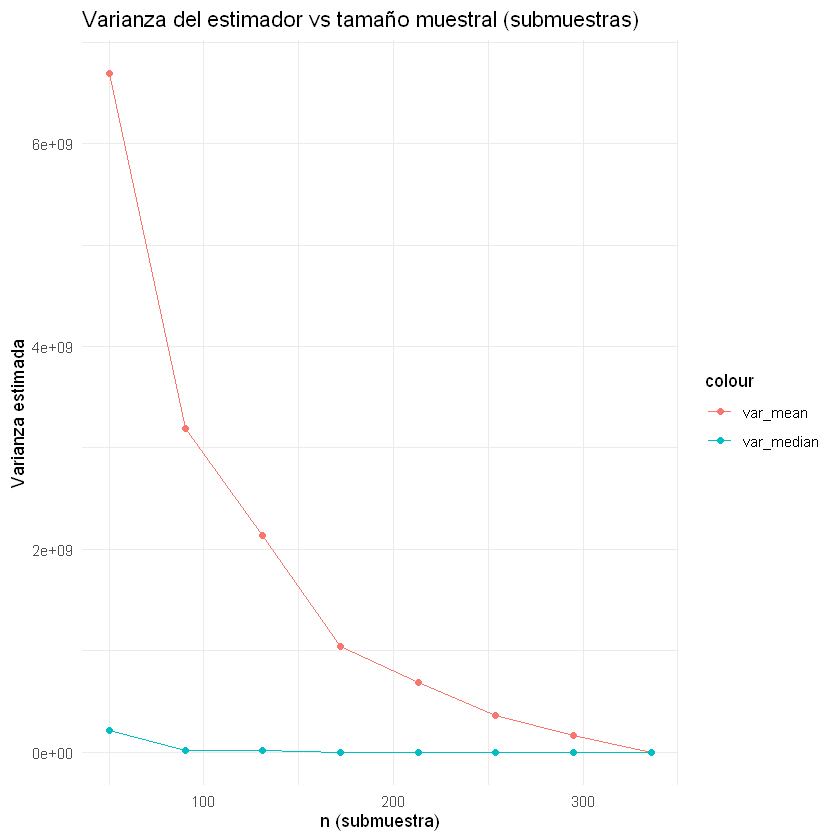

In [15]:
# ---- Celda 6: Consistencia (comportamiento varianza vs n) ------------------
library(dplyr); set.seed(123)

x <- df_var$value
x_nm <- x[!is.na(x)]

if (length(x_nm) > 30) {
  ns <- unique(floor(seq(50, length(x_nm), length.out = 8)))
  reps <- 300  # repeticiones por tamaño (moderado)
  res <- data.frame(n = integer(), var_mean = numeric(), var_median = numeric())
  for (n in ns) {
    ests_mean <- numeric(reps); ests_med <- numeric(reps)
    for (r in 1:reps) {
      s <- sample(x_nm, size = n, replace = FALSE)
      ests_mean[r] <- mean(s)
      ests_med[r] <- median(s)
    }
    res <- rbind(res, data.frame(n = n, var_mean = var(ests_mean), var_median = var(ests_med)))
  }
  print(res)

  # gráfico var vs n
  library(ggplot2)
  pcons <- ggplot(res, aes(x = n)) +
    geom_line(aes(y = var_mean, color = "var_mean")) +
    geom_point(aes(y = var_mean, color = "var_mean")) +
    geom_line(aes(y = var_median, color = "var_median")) +
    geom_point(aes(y = var_median, color = "var_median")) +
    labs(title = "Varianza del estimador vs tamaño muestral (submuestras)",
         x = "n (submuestra)", y = "Varianza estimada") + theme_minimal()
  print(pcons)
  ggsave(filename = file.path(out_dir, "consistencia_var_vs_n.png"), plot = pcons, width = 7, height = 4)
  message("Gráfico de consistencia guardado en: ", file.path(out_dir, "consistencia_var_vs_n.png"))

  cat("\nComentario (Consistencia):\nSi la varianza del estimador (mean o median) disminuye al crecer n, evidencia consistencia.\n")
} else cat("No hay suficientes datos (>30) para estudiar consistencia por submuestreo.\n")


In [16]:
# ---- Celda 7: Eficiencia y Sintaxis empleada --------------------------------
library(dplyr)
set.seed(42)

x <- df_var$value
x_nm <- x[!is.na(x)]

if (length(x_nm) > 10) {
  # bootstrap var estimadas
  B <- 1000
  b_mean <- boot(x_nm, statistic = function(d,i) mean(d[i]), R = B)
  b_median <- boot(x_nm, statistic = function(d,i) median(d[i]), R = B)
  var_mean_boot <- var(b_mean$t)
  var_median_boot <- var(b_median$t)
  rel_eff <- var_median_boot / var_mean_boot

  cat("Eficiencia (empírica via bootstrap):\n")
  cat(" Var(mean) bootstrap:", var_mean_boot, "\n")
  cat(" Var(median) bootstrap:", var_median_boot, "\n")
  cat(" Rel. effic (var_median / var_mean):", rel_eff, "\n")

  cat("\nComentario (Eficiencia):\n")
  if (rel_eff > 1) cat(" La media es más eficiente (menor var) que la mediana en esta muestra.\n") else cat(" La mediana es más eficiente en esta muestra.\n")
} else cat("No hay suficientes datos para evaluar eficiencia.\n")

# Sintaxis empleada (imprimir fragmento con comandos clave para el documento)
cat("\n--- Sintaxis clave usada en este análisis ---\n")
cat("1) Limpieza money: clean_numeric2(...) \n")
cat("2) Descriptivos: tabla_vertical (N, N missing, Min, Q1, Median, Mean, Q3, Max, SD, IQR)\n")
cat("3) Gráficas guardadas en:", file.path(out_dir, "plots"), "\n")
cat("4) IC mean (t): t.test(x)$conf.int  (o calculado manualmente)\n")
cat("5) Bootstrap bias y CI: uso package 'boot' (boot(...), boot.ci(...))\n")
cat("6) Consistencia: submuestreo comparando var(estimator) vs n\n")
cat("7) Eficiencia: comparar var_bootstrap(estimator)\n")


Eficiencia (empírica via bootstrap):
 Var(mean) bootstrap: 1120377604 
 Var(median) bootstrap: 1959954 
 Rel. effic (var_median / var_mean): 0.001749369 

Comentario (Eficiencia):
 La mediana es más eficiente en esta muestra.

--- Sintaxis clave usada en este análisis ---
1) Limpieza money: clean_numeric2(...) 
2) Descriptivos: tabla_vertical (N, N missing, Min, Q1, Median, Mean, Q3, Max, SD, IQR)
3) Gráficas guardadas en: analisis_P3087S1_check/plots 
4) IC mean (t): t.test(x)$conf.int  (o calculado manualmente)
5) Bootstrap bias y CI: uso package 'boot' (boot(...), boot.ci(...))
6) Consistencia: submuestreo comparando var(estimator) vs n
7) Eficiencia: comparar var_bootstrap(estimator)
